In [1]:
#!git clone https://github.com/navpreetsingh9/S11-Assignment-Solution.git

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import argparse

from models.resnet import ResNet18, ResNet34
from utils.dataset import means, stds, class_map, Cifar10SearchDataset
from utils.transforms import CustomResnetTransforms
from utils.utils import show_images, print_summary, get_incorrect_predictions, denormalize_image
from utils.utils import plot_incorrect_predictions, plot_network_performance, show_gradcam
from utils.train import train, test, get_sgd_optimizer, get_adam_optimizer, get_onecyclelr_scheduler, get_lr_finder
from utils.train import train_losses, test_losses, train_acc, test_acc

c:\users\navpr\appdata\local\programs\python\python38\lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()
print("CUDA Available?", torch.cuda.is_available())
seed = 100
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

CUDA Available? True


In [4]:
# Hyperparameters

batch_size = 256
lr = 0.01
weight_decay = 5e-4
use_scheduler = True
end_lr = True
epochs = 20

In [5]:
# Data
print('==> Preparing data..')
train_transforms = CustomResnetTransforms.train_transforms(means, stds)
test_transforms = CustomResnetTransforms.test_transforms(means, stds)

train_dataset = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test_dataset = Cifar10SearchDataset(root='./data', train=False,
                                    download=True, transform=test_transforms)

dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4,
                        pin_memory=True) if cuda else dict(shuffle=True, batch_size=batch_size)

train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


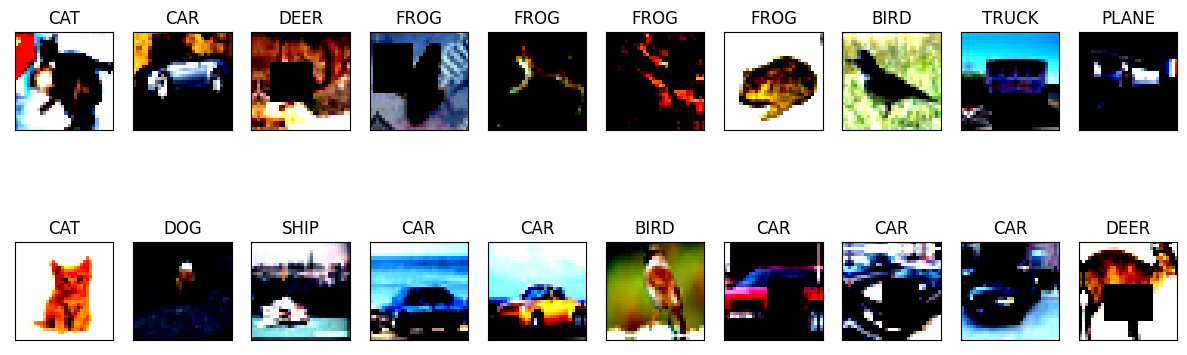

In [6]:
show_images(train_loader, class_map, count=20)

In [7]:
# Model
print('==> Building model..')
model = ResNet18().to(device)
print_summary(model, (1, 3, 36, 36)) # With padding=4

==> Building model..


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 36, 36]           1,728
├─BatchNorm2d: 1-2                       [1, 64, 36, 36]           128
├─Sequential: 1-3                        [1, 64, 36, 36]           --
│    └─BasicBlock: 2-1                   [1, 64, 36, 36]           --
│    │    └─Conv2d: 3-1                  [1, 64, 36, 36]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 36, 36]           128
│    │    └─Conv2d: 3-3                  [1, 64, 36, 36]           36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 36, 36]           128
│    │    └─Sequential: 3-5              [1, 64, 36, 36]           --
│    └─BasicBlock: 2-2                   [1, 64, 36, 36]           --
│    │    └─Conv2d: 3-6                  [1, 64, 36, 36]           36,864
│    │    └─BatchNorm2d: 3-7             [1, 64, 36, 36]           

==> Initializing optimizer and scheduler..


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.32E-02


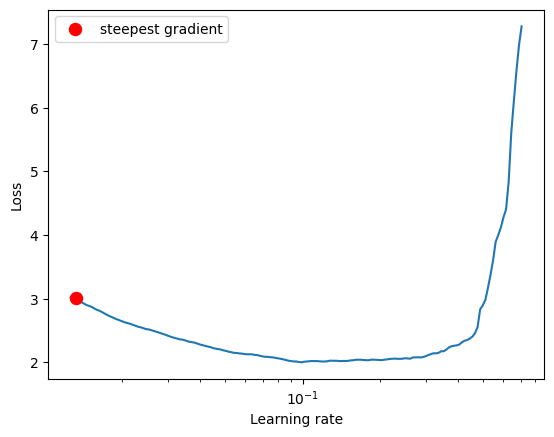

In [8]:
print('==> Initializing optimizer and scheduler..')
criterion = nn.CrossEntropyLoss()
optimizer = get_adam_optimizer(model, lr=lr, weight_decay=weight_decay)

if use_scheduler:
    max_lr = get_lr_finder(model, optimizer, criterion, device, train_loader, end_lr)
    scheduler = get_onecyclelr_scheduler(optimizer, max_lr, steps_per_epoch=len(train_loader), epochs=epochs)

In [ ]:
print('==> Training the model..')
for epoch in range(1,epochs+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, criterion)
    test(model, device, test_loader, criterion)
    if use_scheduler:
        scheduler.step()

==> Training the model..
EPOCH: 1


  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 5374/10000 (53.74%)

EPOCH: 2


  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 5604/10000 (56.04%)

EPOCH: 3


  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 6906/10000 (69.06%)

EPOCH: 4


  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 7235/10000 (72.35%)

EPOCH: 5


  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 7072/10000 (70.72%)

EPOCH: 6


  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 7480/10000 (74.80%)

EPOCH: 7


  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 7418/10000 (74.18%)

EPOCH: 8


  0%|          | 0/196 [00:00<?, ?it/s]

In [ ]:
print('==> Finished Training..')
plot_network_performance(epochs, train_losses, test_losses, train_acc, test_acc)

In [ ]:
incorrect = get_incorrect_predictions(model, test_loader, device)
plot_incorrect_predictions(incorrect, class_map, count=20)

In [ ]:
show_gradcam(model, test_loader, class_map, cuda, means, stds, count=20)